In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using DataFrames
using MCMCDiagnostics

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
# Packages for diagnostic test #

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
Sys.free_memory()/(2^20*1024)

25.17278289794922

In [5]:
@load "../../results/BSLMC/BSLMC_sum_data_nopredC.jld"

13-element Array{Symbol,1}:
 :Y_ord     
 :S_indx    
 :U_indx    
 :M1_Sind   
 :M2_Sind   
 :M1_ind    
 :M2_ind    
 :K         
 :p         
 :q         
 :N_sam     
 :N_pre_burn
 :NM        

In [6]:
@load "../../results/BSLMC/BSLMC_mean_var_nopredC.jld"

10-element Array{Symbol,1}:
 :ω_incp_sam_mean  
 :ω_incp_sam_var   
 :Y_m1_sam_mean    
 :Y_m1_sam_var     
 :Y_m2_sam_mean    
 :Y_m2_sam_var     
 :ω_incp_M_sam_mean
 :ω_incp_M_sam_var 
 :Y_M_sam_mean     
 :Y_M_sam_var      

In [7]:
#load data
using CSV
ϕ_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC/ϕ_sam_nopredC.csv"));
N_sam = Integer(length(ϕ_sam) / K - 1);
ind_ϕ_sam = 1: K :(K * N_sam + 1);
A_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC/A_sam_nopredC.csv"));
ind_A_sam = 1: K :(K * (N_sam - 1) + 1);
γ_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC/γ_sam_nopredC.csv"));
ind_γ_sam = 1: (p + K) :((p + K) * N_sam + 1);
Σ_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC/Σ_sam_nopredC.csv"));
ind_Σ_sam = 1: q :(q * N_sam + 1);
ω_cov_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC/ω_cov_sam_nopredC.csv"));
ind_ω_cov_sam = 1: q :(q * (N_sam - 1) + 1);

In [8]:
N_sam

10000

In [9]:
mean(A_sam[ind_A_sam])

0.11381328066490709

In [10]:
mean(A_sam[ind_A_sam .+ 1])

0.09804095240292991

In [11]:
size(Y_ord)

(1020000, 2)

In [12]:
NM

22146

Posterior prediction

# MCMC Chain check

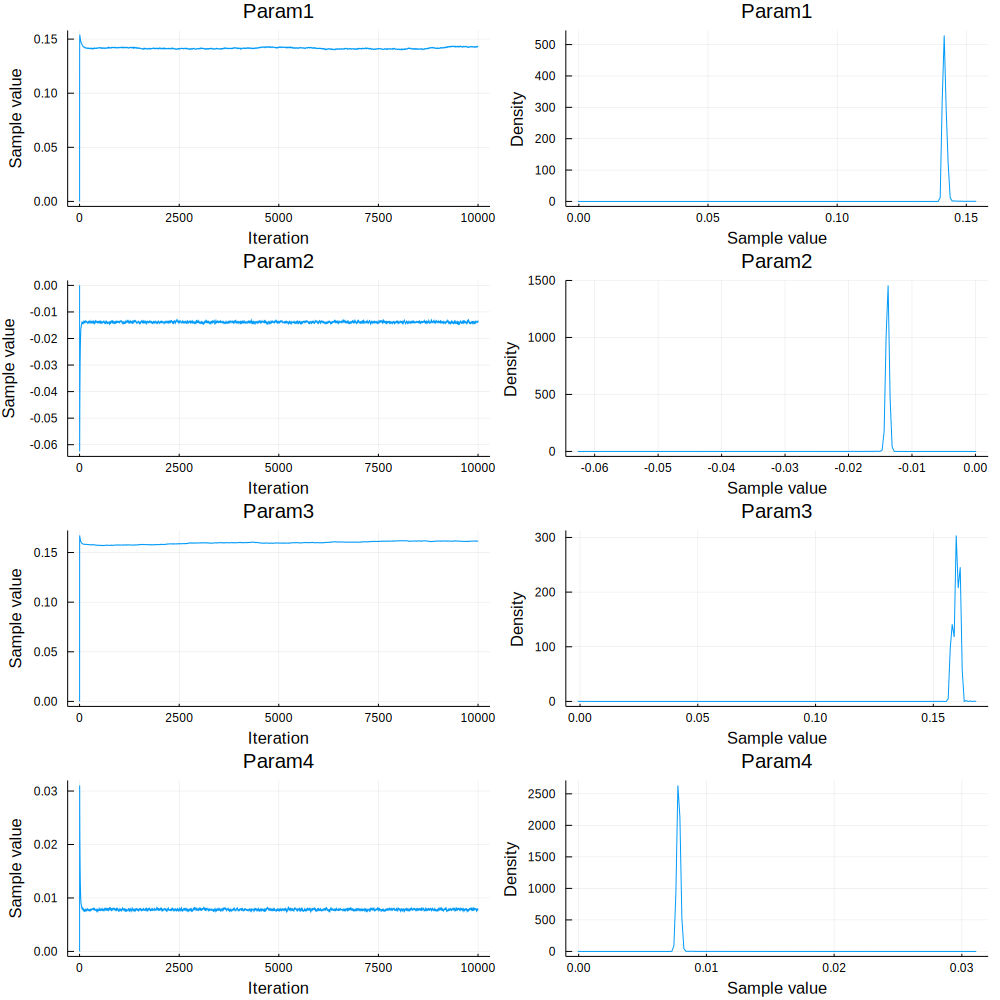

In [13]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, (p ) * q, 1);
β_pos_sam[:, :, 1] = hcat([γ_sam[ind_γ_sam .+ (i - 1), j][1:(N_sam + 1)] for i in 1:2, j in 1:q]...);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

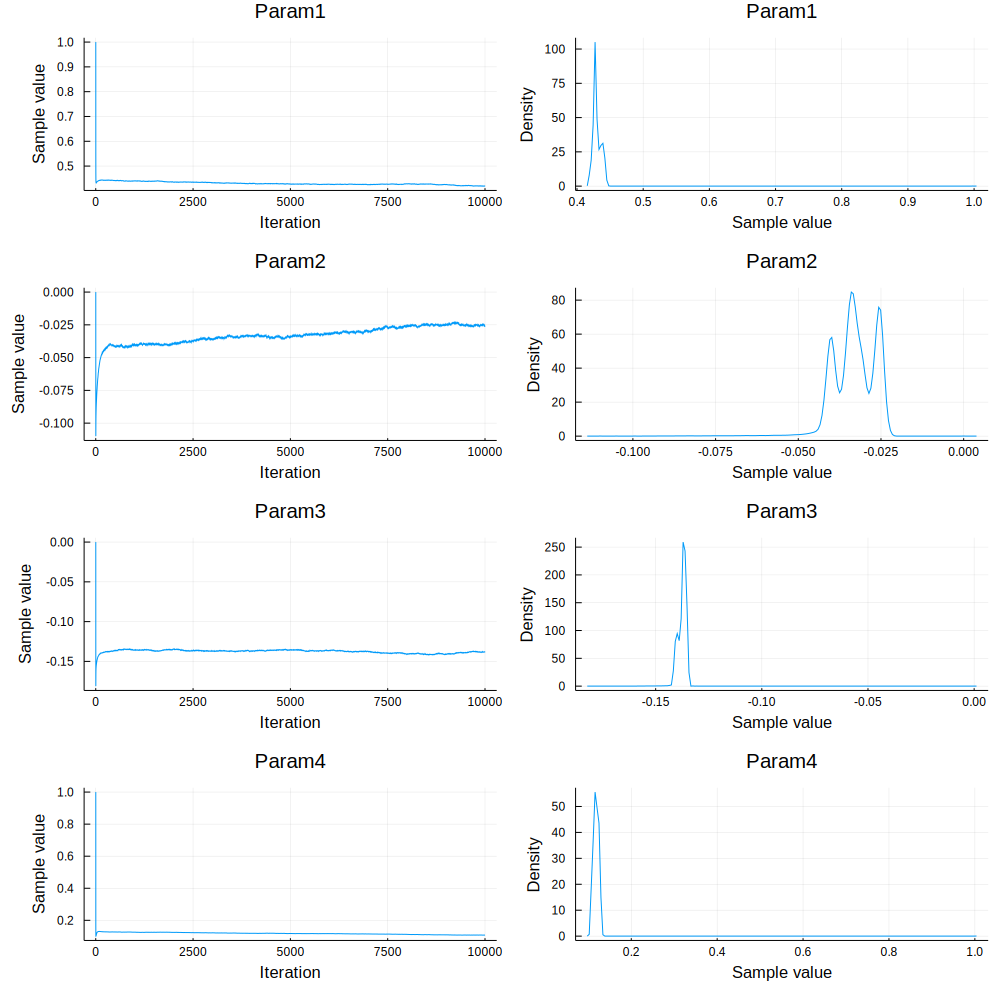

In [14]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K * q, 1);
Λ_pos_sam[:, :, 1] = hcat([γ_sam[ind_γ_sam .+ (i - 1), j][1:(N_sam + 1)] for i in (p + 1):(p + K), j in 1:q]...);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

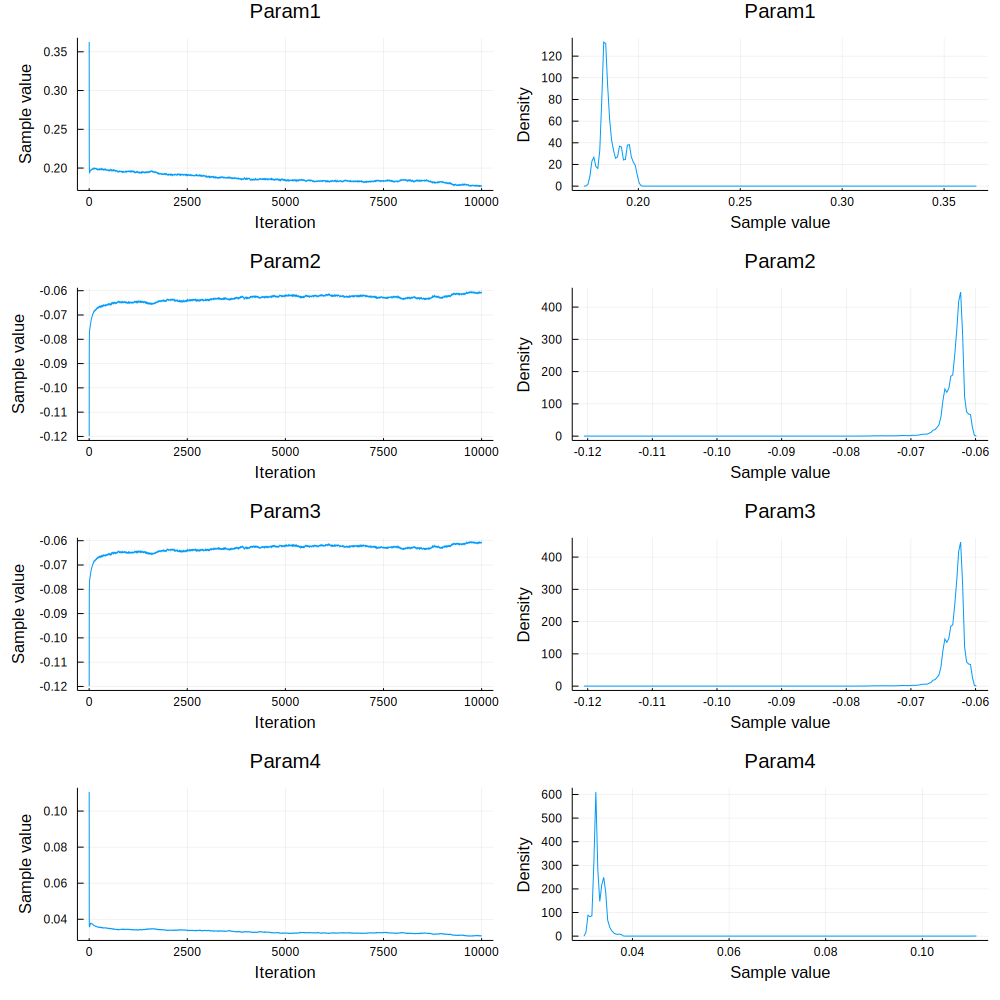

In [15]:
Ω_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
for i in 1:(N_sam)
    Ω_pos_sam[i, :, 1] = vec(γ_sam[(ind_γ_sam[i + 1] + 2):(ind_γ_sam[i + 1] + 3), 
            1:2]'γ_sam[(ind_γ_sam[i + 1] + 2):(ind_γ_sam[i + 1] + 3), 1:2] + 
        Σ_sam[(ind_Σ_sam[i + 1]):(ind_Σ_sam[i + 1] + 1), 1:2])
end
Ω_chain = Chains(Ω_pos_sam)
pΩ = plot(Ω_chain)

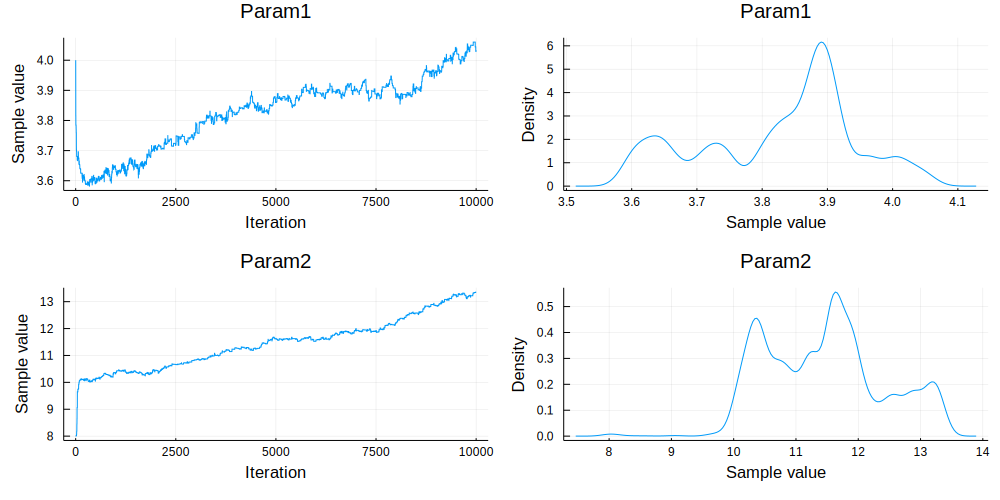

In [16]:
ϕ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K, 1);
ϕ_pos_sam[:, :, 1] = hcat([(ϕ_sam[ind_ϕ_sam .+ (i - 1)][1:(N_sam + 1)]) for i in 1:K]...);
ϕ_chain = Chains(ϕ_pos_sam);
pϕ = plot(ϕ_chain)

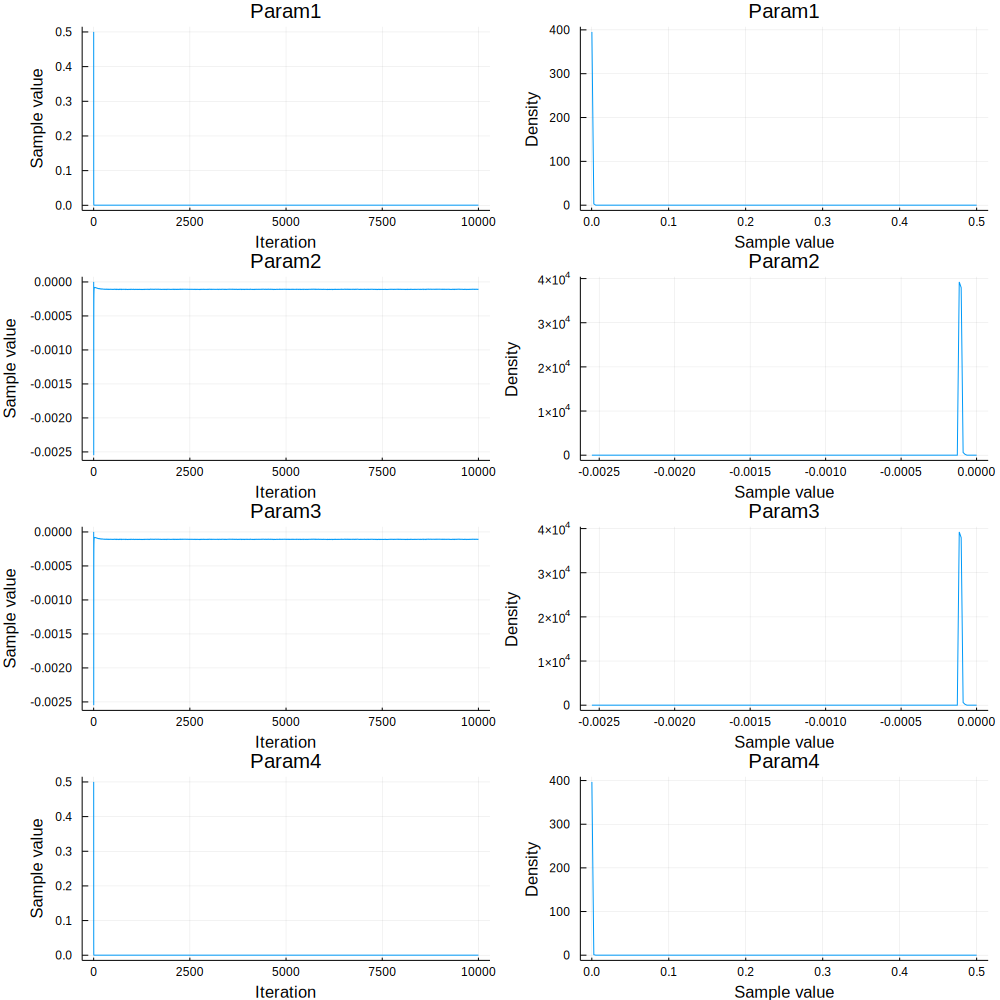

In [17]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat([Σ_sam[ind_Σ_sam .+ (i - 1), j][1:(N_sam + 1)] for i in 1:q, j in 1:q]...);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

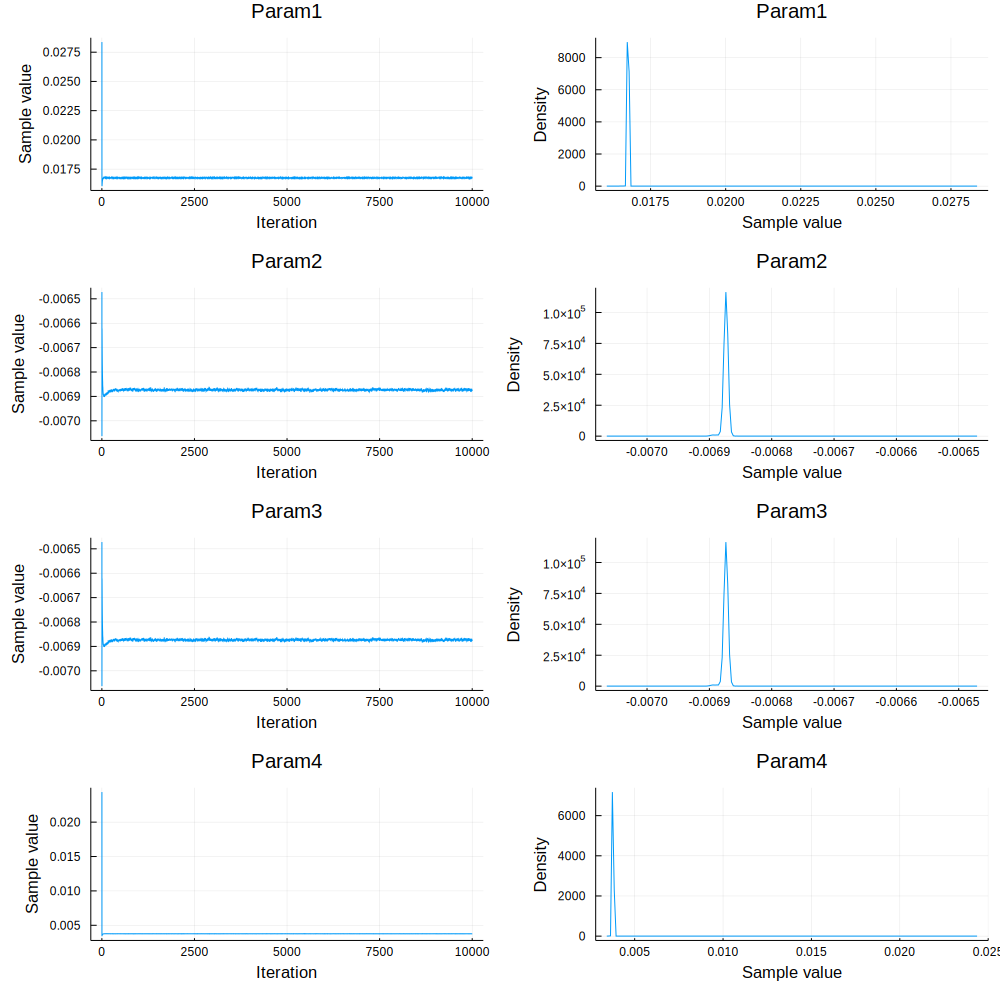

In [18]:
ω_cov_pos_sam = Array{Float64, 3}(undef, N_sam , q * q, 1);
ω_cov_pos_sam[:, :, 1] = hcat([ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][1:(N_sam )] for i in 1:q, j in 1:q]...);
ω_cov_chain = Chains(ω_cov_pos_sam);
pωcov = plot(ω_cov_chain)

# Posterior Inference 

In [32]:
N_pre_burn = Integer(0.75*N_sam);
half_sample = Integer((N_sam - N_pre_burn)/2)

1250

In [33]:
# ESS-slope #
ESS_slope = fill(0.0, p, q)
MCSE_slope = fill(0.0, p, q)
Rhat_slope = fill(0.0, p, q)
for i in 1:p
    for j in 1:q
        ESS_slope[i, j] = 
            effective_sample_size(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)]);
        MCSE_slope[i, j] = std(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)]) / 
            sqrt(ESS_slope[i, j]);
        Rhat_slope[i, j] = potential_scale_reduction(
            γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
            γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam])
    end
end   
[ESS_slope, MCSE_slope, Rhat_slope]

3-element Array{Array{Float64,2},1}:
 [2.4001560208530743 15.428852956709084; 143.25476972462013 157.66282162257454]         
 [0.0006082663334232561 4.755893289848171e-5; 1.950833823781879e-5 9.316154443370057e-6]
 [2.7808290661004937 1.1616586990382436; 1.002960976846795 1.0043824886257362]          

In [34]:
# ESS-cov #
ESS_ω_cov = fill(0.0, q, q)
MCSE_ω_cov = fill(0.0, q, q)
Rhat_ω_cov = fill(0.0, q, q)
for j in 1:q
    for i in 1:q
        ESS_ω_cov[i, j] = 
            effective_sample_size(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]);
        MCSE_ω_cov[i, j] = std(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) / 
            sqrt(ESS_ω_cov[i, j]);
        Rhat_ω_cov[i, j] = potential_scale_reduction(
            ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
            ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam]);
    end
end
[ESS_ω_cov, MCSE_ω_cov, Rhat_ω_cov]

3-element Array{Array{Float64,2},1}:
 [100.42318905025036 241.2496713568006; 241.2496713568006 270.7889208195698]            
 [7.136837379719678e-7 1.955837304959615e-7; 1.955837304959615e-7 1.0825901101830315e-7]
 [1.0005746397447184 1.0042102053983974; 1.0042102053983974 1.0162703037380536]         

In [35]:
# ESS-ϕ #
ESS_ϕ = fill(0.0, K)
MCSE_ϕ = fill(0.0, K)
Rhat_ϕ = fill(0.0, K)
for i in 1:K
    ESS_ϕ[i] = 
        effective_sample_size(ϕ_pos_sam[(N_pre_burn + 1):N_sam, i, 1]);
    MCSE_ϕ[i] = std(ϕ_pos_sam[(N_pre_burn + 1):N_sam, i, 1]) / sqrt(ESS_ϕ[i]);
    Rhat_ϕ[i] = potential_scale_reduction(
        ϕ_pos_sam[(N_pre_burn + 1):(N_pre_burn + half_sample), i, 1],
        ϕ_pos_sam[(N_pre_burn + half_sample + 1):N_sam, i, 1]);
end
[ESS_ϕ, MCSE_ϕ, Rhat_ϕ]

3-element Array{Array{Float64,1},1}:
 [2.2039221326744465, 1.8889127647470436]  
 [0.038026204261811435, 0.3199538193084472]
 [2.6789723216037316, 2.619063276508561]   

In [36]:
# ESS-Σ #
ESS_Σ = fill(0.0, q, q)
MCSE_Σ = fill(0.0, q, q)
Rhat_Σ = fill(0.0, q, q)
for i in 1:q
    for j in 1:q
        ESS_Σ[i, j] = 
            effective_sample_size(Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]);
        MCSE_Σ[i, j] = std(Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) / sqrt(ESS_Σ[i, j]);
        Rhat_Σ[i, j] = potential_scale_reduction(
            Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
            Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam]);
    end
end
[ESS_Σ, MCSE_Σ, Rhat_Σ]

3-element Array{Array{Float64,2},1}:
 [24.785255400680732 16.800795396010823; 16.800795396010823 13.922906868397945]         
 [3.9894812861634e-7 2.3356459280968868e-7; 2.3356459280968868e-7 1.6208666375380896e-7]
 [1.0043636186777214 1.098698822046697; 1.098698822046697 1.2079837971773117]           

In [37]:
summary_table = Array{Float64, 2}(undef, 12, 8);
summary_table[1, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 1, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 1, 1], [0.5, 0.025, 0.975]),
    ESS_slope[1, 1], MCSE_slope[1, 1], Rhat_slope[1, 1]);
summary_table[2, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 2, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 2, 1], [0.5, 0.025, 0.975]),
    ESS_slope[1, 2], MCSE_slope[1, 2], Rhat_slope[1, 2]);
summary_table[3, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 3, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 3, 1], [0.5, 0.025, 0.975]),
    ESS_slope[2, 1], MCSE_slope[2, 1], Rhat_slope[2, 1]);
summary_table[4, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 4, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 4, 1], [0.5, 0.025, 0.975]),
    ESS_slope[2, 2], MCSE_slope[2, 2], Rhat_slope[2, 2]);
summary_table[5, :] = vcat(0.0, mean(Σ_sam[ind_Σ_sam, 1][(N_pre_burn + 1):(N_sam + 1)]),
    quantile(Σ_sam[ind_Σ_sam, 1][(N_pre_burn + 1):(N_sam + 1)], [0.5, 0.025, 0.975]),
    ESS_Σ[1, 1], MCSE_Σ[1, 1], Rhat_Σ[1, 1]);
summary_table[6, :] = vcat(0.0, mean(Σ_sam[ind_Σ_sam .+ 1, 1][(N_pre_burn + 1):(N_sam + 1)]),
    quantile(Σ_sam[ind_Σ_sam .+ 1, 1][(N_pre_burn + 1):(N_sam + 1)], [0.5, 0.025, 0.975]),
    ESS_Σ[2, 1], MCSE_Σ[2, 1], Rhat_Σ[2, 1]);
summary_table[7, :] = vcat(0.0, mean(Σ_sam[ind_Σ_sam .+ 1, 2][(N_pre_burn + 1):(N_sam + 1)]),
    quantile(Σ_sam[ind_Σ_sam .+ 1, 2][(N_pre_burn + 1):(N_sam + 1)], [0.5, 0.025, 0.975]),
    ESS_Σ[2, 2], MCSE_Σ[2, 2], Rhat_Σ[2, 2]);
summary_table[8, :] = vcat(0.0, mean(ω_cov_sam[ind_ω_cov_sam, 1][(N_pre_burn + 1):N_sam]),
    quantile(ω_cov_sam[ind_ω_cov_sam, 1][(N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]),
    ESS_ω_cov[1, 1], MCSE_ω_cov[1, 1], Rhat_ω_cov[1, 1]);
summary_table[9, :] = vcat(0.0, mean(ω_cov_sam[ind_ω_cov_sam .+ 1, 1][(N_pre_burn + 1):N_sam]),
    quantile(ω_cov_sam[ind_ω_cov_sam .+ 1, 1][(N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]),
    ESS_ω_cov[2, 1], MCSE_ω_cov[2, 1], Rhat_ω_cov[2, 1]);
summary_table[10, :] = vcat(0.0, mean(ω_cov_sam[ind_ω_cov_sam .+ 1, 2][(N_pre_burn + 1):N_sam]),
    quantile(ω_cov_sam[ind_ω_cov_sam .+ 1, 2][(N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]),
    ESS_ω_cov[2, 2], MCSE_ω_cov[2, 2], Rhat_ω_cov[2, 2]);
summary_table[11, :] = vcat(0.0, mean(ϕ_sam[ind_ϕ_sam][(N_pre_burn + 1):N_sam]),
    quantile(ϕ_sam[ind_ϕ_sam][(N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]),
    ESS_ϕ[1], MCSE_ϕ[1], Rhat_ϕ[1]);
summary_table[12, :] = vcat(0.0, mean(ϕ_sam[ind_ϕ_sam .+ 1][(N_pre_burn + 1):N_sam]),
    quantile(ϕ_sam[ind_ϕ_sam .+ 1][(N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]),
    ESS_ϕ[2], MCSE_ϕ[2], Rhat_ϕ[2]);
summary_table = round.(summary_table; digits = 8);
rnames = ["β[1, 1]", "β[1, 2]", 
    "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]", 
    "cov(ω)[1, 1]", "cov(ω)[1, 2]", "cov(ω)[2, 2]", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%" "ESS" "MCSE" "Rhat"], markdown)

|              | true |        mean |      median |        2.5% |       97.5%  ⋯
|--------------|------|-------------|-------------|-------------|------------- ⋯
|      β[1, 1] |  0.0 |  0.14171073 |  0.14148727 |  0.14050365 |  0.14325249  ⋯
|      β[1, 2] |  0.0 | -0.01385082 | -0.01384707 | -0.01430249 | -0.01336837  ⋯
|      β[2, 1] |  0.0 |  0.16151361 |  0.16151853 |  0.16112246 |  0.16185002  ⋯
|      β[2, 2] |  0.0 |   0.0078348 |  0.00784175 |  0.00759724 |  0.00804874  ⋯
|      Σ[1, 1] |  0.0 |  0.00035093 |  0.00035089 |  0.00034735 |   0.0003548  ⋯
|      Σ[1, 2] |  0.0 | -0.00010842 | -0.00010841 | -0.00011021 | -0.00010653  ⋯
|      Σ[2, 2] |  0.0 |   0.0001074 |  0.00010739 |   0.0001062 |  0.00010853  ⋯
| cov(ω)[1, 1] |  0.0 |  0.01675083 |  0.01675087 |  0.01673687 |  0.01676487  ⋯
| cov(ω)[1, 2] |  0.0 | -0.00687332 | -0.00687324 | -0.00687955 |  -0.0068676  ⋯
| cov(ω)[2, 2] |  0.0 |  0.00376397 |  0.00376393 |  0.00376057 |  0.00376757  ⋯
|           ϕ1 |  0.0 |  3.9

In [38]:
pretty_table(summary_table[:, [1, 3, 7, 8, 9]],  ["" "mean" "ESS" "MCSE" "Rhat"], markdown)

|              |        mean |          ESS |       MCSE |       Rhat |
|--------------|-------------|--------------|------------|------------|
|      β[1, 1] |  0.14171073 |   2.40015602 | 0.00060827 | 2.78082907 |
|      β[1, 2] | -0.01385082 |  15.42885296 |   4.756e-5 |  1.1616587 |
|      β[2, 1] |  0.16151361 | 143.25476972 |   1.951e-5 | 1.00296098 |
|      β[2, 2] |   0.0078348 | 157.66282162 |    9.32e-6 | 1.00438249 |
|      Σ[1, 1] |  0.00035093 |   24.7852554 |     4.0e-7 | 1.00436362 |
|      Σ[1, 2] | -0.00010842 |   16.8007954 |     2.3e-7 | 1.09869882 |
|      Σ[2, 2] |   0.0001074 |  13.92290687 |     1.6e-7 |  1.2079838 |
| cov(ω)[1, 1] |  0.01675083 | 100.42318905 |     7.1e-7 | 1.00057464 |
| cov(ω)[1, 2] | -0.00687332 | 241.24967136 |     2.0e-7 | 1.00421021 |
| cov(ω)[2, 2] |  0.00376397 | 270.78892082 |     1.1e-7 |  1.0162703 |
|           ϕ1 |  3.95170711 |   2.20392213 |  0.0380262 | 2.67897232 |
|           ϕ2 | 12.71431738 |   1.88891276 | 0.31995382 | 2.619

In [26]:
# MAE #
MAE1 = (sum(abs.(Y_ord[U_indx, 1] - Y_M_sam_mean[:, 1])) + sum(abs.(Y_m1_sam_mean - Y_ord[M1_ind, 1]))) / 
(length(M1_ind) + length(U_indx));
MAE2 = (sum(abs.(Y_ord[U_indx, 2] - Y_M_sam_mean[:, 2])) + sum(abs.(Y_m2_sam_mean - Y_ord[M2_ind, 2]))) / 
(length(M2_ind) + length(U_indx));
MAE = (sum(abs.(Y_ord[U_indx, :] - Y_M_sam_mean)) + sum(abs.(Y_m1_sam_mean - Y_ord[M1_ind, 1]))
           + sum(abs.(Y_m2_sam_mean - Y_ord[M2_ind, 2]))) / (length(M1_ind) + length(M2_ind) + 2 * length(U_indx));
round.([MAE1 MAE2 MAE], digits = 4)

1×3 Array{Float64,2}:
 0.0191  0.0109  0.015

In [27]:
# RMSPE #
MSPE1 = (sum((Y_ord[U_indx, 1] - Y_M_sam_mean[:, 1]).^2) + sum((Y_m1_sam_mean - Y_ord[M1_ind, 1]).^2)) / 
(length(M1_ind) + length(U_indx));
RMSPE1 = sqrt(MSPE1); 
MSPE2 = (sum((Y_ord[U_indx, 2] - Y_M_sam_mean[:, 2]).^2) + sum((Y_m2_sam_mean - Y_ord[M2_ind, 2]).^2)) / 
(length(M2_ind) + length(U_indx))
RMSPE2 = sqrt(MSPE2); 
MSPE = (sum((Y_ord[U_indx, :] - Y_M_sam_mean).^2) + sum((Y_m1_sam_mean - Y_ord[M1_ind, 1]).^2 )
           + sum((Y_m2_sam_mean - Y_ord[M2_ind, 2]).^2)) / (length(M1_ind) + length(M2_ind) + 2 * length(U_indx))
RMSPE = sqrt(MSPE)
round.([RMSPE1 RMSPE2 RMSPE], digits = 4)

1×3 Array{Float64,2}:
 0.0326  0.0171  0.026

In [28]:
# CRPS #

CRPS_m1 = [(sqrt(Y_m1_sam_var[i]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i]) / sqrt(Y_m1_sam_var[i])) -
        ((Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i]) / sqrt(Y_m1_sam_var[i])) * 
        (2* cdf(Normal(), (Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i]) / sqrt(Y_m1_sam_var[i])) - 1 )))
        for i in 1:length(M1_ind)];
CRPS_m2 = [(sqrt(Y_m2_sam_var[i]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i]) / sqrt(Y_m2_sam_var[i])) -
        ((Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i]) / sqrt(Y_m2_sam_var[i])) * 
        (2* cdf(Normal(), (Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i]) / sqrt(Y_m2_sam_var[i])) - 1 )))
        for i in 1:length(M2_ind)];

CRPS_U = [(sqrt(Y_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) -
        ((Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) - 1)))
        for i in 1:NM, j in 1:q];

CRPS1 = (sum(CRPS_U[:, 1]) + sum(CRPS_m1)) / (length(M1_ind) + NM);
CRPS2 = (sum(CRPS_U[:, 2]) + sum(CRPS_m2)) / (length(M2_ind) + NM);
CRPS = (sum(CRPS_U) + sum(CRPS_m1) + sum(CRPS_m2))/(2 * NM + length(M1_ind) + (length(M2_ind)));
round.([CRPS1 CRPS2 CRPS], digits = 5)

1×3 Array{Float64,2}:
 -0.01561  -0.00879  -0.0122

In [29]:
# CVG #
N_Inf_burn = 1;
count_Y_M = fill(0.0, q);
for j in 1:q
    for i in 1:NM
        count_Y_M[j] = count_Y_M[j] + 
        (((Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) < Y_ord[U_indx[i], j]) && 
            ((Y_M_sam_mean[i, j] + 1.96 * sqrt(Y_M_sam_var[i, j])) > Y_ord[U_indx[i], j]))
    end
end
for i in 1:length(M1_ind)
    count_Y_M[1] = count_Y_M[1] + 
        (((Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i])) < Y_ord[M1_ind[i], 1]) && 
         ((Y_m1_sam_mean[i] + 1.96 * sqrt(Y_m1_sam_var[i])) > Y_ord[M1_ind[i], 1]))
end
for i in 1:length(M2_ind)
    count_Y_M[2] = count_Y_M[2] + 
        (((Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i])) < Y_ord[M2_ind[i], 2]) && 
         ((Y_m2_sam_mean[i] + 1.96 * sqrt(Y_m2_sam_var[i])) > Y_ord[M2_ind[i], 2]))
end
round.([(count_Y_M[1] / (length(M1_ind) + length(U_indx))) (count_Y_M[2] / 
            (length(M2_ind) + length(U_indx))) (sum(count_Y_M) / (length(M1_ind) + 
                length(M2_ind) + 2 * length(U_indx)))], digits = 4)

1×3 Array{Float64,2}:
 0.9537  0.9466  0.9501

In [30]:
# INT #
INT_m1 = [((2 * 1.96 * sqrt(Y_m1_sam_var[i])) + 
                (2 / 0.05)*(Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i]) - Y_ord[M1_ind[i], 1]) * 
                (Y_ord[M1_ind[i], 1] < (Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i]))) + 
                (2 / 0.05)*(Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i])) * 
                (Y_ord[M1_ind[i], 1] > (Y_m1_sam_mean[i] + 
                1.96 * sqrt(Y_m1_sam_var[i])))) for i in 1:length(M1_ind)]

INT_m2 = [((2 * 1.96 * sqrt(Y_m2_sam_var[i])) + 
                (2 / 0.05)*(Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i]) - Y_ord[M2_ind[i], 2]) * 
                (Y_ord[M2_ind[i], 2] < (Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i]))) + 
                (2 / 0.05)*(Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i])) * 
                (Y_ord[M2_ind[i], 2] > (Y_m2_sam_mean[i] + 
                1.96 * sqrt(Y_m2_sam_var[i])))) for i in 1:length(M2_ind)]

INT_U = [((2 * 1.96 * sqrt(Y_M_sam_var[i, j])) + 
                (2 / 0.05)*(Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i]) - Y_ord[U_indx[i], j]) * 
                (Y_ord[U_indx[i], j] < (Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j]))) + 
                (2 / 0.05)*(Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) * 
                (Y_ord[U_indx[i], j] > (Y_M_sam_mean[i, j] + 
                1.96 * sqrt(Y_M_sam_var[i, j])))) for i in 1:NM, j in 1:q]

INT1 = (sum(INT_U[:, 1]) + sum(INT_m1)) / (length(M1_ind) + NM);
INT2 = (sum(INT_U[:, 2]) + sum(INT_m2)) / (length(M2_ind) + NM);
INT = (sum(INT_U) + sum(INT_m1) + sum(INT_m2))/(2 * NM + length(M1_ind) + (length(M2_ind)));

round.([INT1 INT2 INT], digits = 5)

1×3 Array{Float64,2}:
 0.19653  0.09959  0.14806

In [31]:
@time @load "../../data/LMC_data/LMC_data_small_expanded.jld"

  3.963611 seconds (3.45 M allocations: 532.660 MiB, 10.78% gc time)


14-element Array{Symbol,1}:
 :U_indx     
 :S_indx     
 :N          
 :n          
 :m          
 :NN         
 :nnIndx_col 
 :nnIndx_row 
 :NM         
 :MnnIndxLU  
 :MnnIndx    
 :Mnndists   
 :coords     
 :coords_pred

In [64]:
size(Y_ord)

(1020000, 2)

In [ ]:
using RData
data_cleaned = load("../../data/rawdata/data_cleaned_small_expanded.RData", convert = true)["data_cleaned_small"];

┌ Info: Recompiling stale cache file /home/lu/.julia/compiled/v1.2/RData/idMMA.ji for RData [df47a6cb-8c03-5eed-afd8-b6050d6c41da]
└ @ Base loading.jl:1240


In [25]:
coords_xy = hcat((round.((data_cleaned.x[S_indx] .- 329) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 329),
    (round.((data_cleaned.y[S_indx] .- 168) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 168));
coords_xy_pred = hcat((round.((data_cleaned.x[U_indx] .- 329) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 329),
    (round.((data_cleaned.y[U_indx] .- 168) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 168));
ω_incp_fit = vcat(ω_incp_sam_mean, ω_incp_M_sam_mean); coords_xy_ω = vcat(coords_xy, coords_xy_pred);
Y_fit_1 = vcat(copy(Y_ord[S_indx, 1]), Y_M_sam_mean[:, 1]); Y_fit_1[M1_Sind] = Y_m1_sam_mean;
Y_fit_2 = vcat(copy(Y_ord[S_indx, 2]), Y_M_sam_mean[:, 2]); Y_fit_2[M2_Sind] = Y_m2_sam_mean;


In [26]:
# check the plot of the data 
using RCall
@rput Y_ord
@rput M1_Sind M2_Sind 
@rput S_indx U_indx
@rput coords_xy
@rput coords_xy_ω
@rput ω_incp_fit
@rput Y_fit_1 Y_fit_2
R"""
library(MBA)
library(classInt)
library(RColorBrewer)
library(sp)
library(coda)
library(spBayes)
library(fields)
library(rworldmap)
library(rworldxtra)
library(raster)
library(leaflet)

raw1.data <- data.frame(x = coords_xy[-M1_Sind, 1], y = coords_xy[-M1_Sind, 2], z =  Y_ord[S_indx[-M1_Sind], 1])
raw2.data <- data.frame(x = coords_xy[-M2_Sind, 1], y = coords_xy[-M2_Sind, 2], z =  Y_ord[S_indx[-M2_Sind], 2])
raw1_nomiss.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z =  Y_ord[c(S_indx, U_indx), 1])
raw2_nomiss.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z =  Y_ord[c(S_indx, U_indx), 2])
fit_y1.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = Y_fit_1)
fit_y2.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = Y_fit_2)
fit_incpw1.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = ω_incp_fit[, 1])
fit_incpw2.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = ω_incp_fit[, 2])

coordinates(raw1.data) = ~x+y
gridded(raw1.data) = TRUE
raw1.data = as(raw1.data, "SpatialGridDataFrame")
projection(raw1.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(raw2.data) = ~x+y
gridded(raw2.data) = TRUE
raw2.data = as(raw2.data, "SpatialGridDataFrame")
projection(raw2.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(raw1_nomiss.data) = ~x+y
gridded(raw1_nomiss.data) = TRUE
raw1_nomiss.data = as(raw1_nomiss.data, "SpatialGridDataFrame")
projection(raw1_nomiss.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(raw2_nomiss.data) = ~x+y
gridded(raw2_nomiss.data) = TRUE
raw2_nomiss.data = as(raw2_nomiss.data, "SpatialGridDataFrame")
projection(raw2_nomiss.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_y1.data) = ~x+y
gridded(fit_y1.data) = TRUE
fit_y1.data = as(fit_y1.data, "SpatialGridDataFrame")
projection(fit_y1.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_y2.data) = ~x+y
gridded(fit_y2.data) = TRUE
fit_y2.data = as(fit_y2.data, "SpatialGridDataFrame")
projection(fit_y2.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_incpw1.data) = ~x+y
gridded(fit_incpw1.data) = TRUE
fit_incpw1.data = as(fit_incpw1.data, "SpatialGridDataFrame")
projection(fit_incpw1.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_incpw2.data) = ~x+y
gridded(fit_incpw2.data) = TRUE
fit_incpw2.data = as(fit_incpw2.data, "SpatialGridDataFrame")
projection(fit_incpw2.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"



data <- c(raw1_nomiss.data$z, raw2_nomiss.data$z)
#, fit_y1.data$z, fit_y2.data$z, fit_incpw1.data$z, fit_incpw2.data$z)
surf.brks <- classIntervals(data[!is.na(data)], 500, 'pretty')$brks
col.pal <- colorRampPalette(brewer.pal(11,'RdBu')[11:1])
xlim <- c(range(coords_xy_ω[, 1])[1], range(coords_xy_ω[, 1])[2] + 
            0.13*(range(coords_xy_ω[, 1])[2] - range(coords_xy_ω[, 1])[1])) ;


zlim <- range(data[!is.na(data)])

# size for the mapping of w               
width <- 360*1.2
height <- 360
pointsize <- 16


png(paste("../../pics/BSLMC_map-raw1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw1.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_map-raw2.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw2.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_map-raw1_nomiss.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw1_nomiss.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_map-raw2_nomiss.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw2_nomiss.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()


png(paste("../../pics/BSLMC_map-fit1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_y1.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_map-fit2.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_y2.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_map-incpw1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_incpw1.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_map-incpw2.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_incpw2.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

"""

┌ Warning: RCall.jl: Loading required package: magic
│ Loading required package: abind
│ Loading required package: Formula
│ Loading required package: Matrix
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113
┌ Warning: RCall.jl: Loading required package: spam
│ Loading required package: dotCall64
│ Loading required package: grid
│ Spam version 2.2-2 (2019-03-07) is loaded.
│ Type 'help( Spam)' or 'demo( spam)' for a short introduction 
│ and overview of this package.
│ Help for individual functions is also obtained by adding the
│ suffix '.spam' to the function name, e.g. 'help( chol.spam)'.
│ 
│ Attaching package: ‘spam’
│ 
│ The following object is masked from ‘package:Matrix’:
│ 
│     det
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     backsolve, forwardsolve
│ 
│ Loading required package: maps
│ See https://github.com/NCAR/Fields for
│  an extensive vignette, other supplements and source code 
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:

RObject{IntSxp}
null device 
          1 
